# Web Scraping Kost di Jakarta Selatan dari Sewakost.com

Pada notebook ini akan dilakukan scraping informasi kost-kostan di Jakarta Selatan dari sewakost.com menggunakan `BeautifulSoup`. Hasil scraping akan disimpan ke dalam file .tsv (tab separated value) yang kemudian akan dilakukan analisis lanjutan. Dari data kost-kostan ini, akan dilakukan analisis terhadap jumlah kost berdasarkan jenis dan fasilitas, serta analisis harga kost-kostan terhadap fasilitas ac, wifi maupun kamar mandi dalam.

Tahapan yang akan dilakukan meliputi:
1. Scraping informasi kost
2. Persiapan dan pembersihan dataset
3. Analisis jumlah serta harga kost terhadap fasilitas

# Proses Scraping

Tahapan scraping yang dilakukan antara lain:
1. Mengakses url daftar kost di [Jakarta Selatan](https://www.sewakost.com/jakarta/selatan/)
2. Mendapatkan jumlah halaman
3. Mengakses setiap halaman dan mengambil informasi kost (nama, url, harga)
4. Mengakses setiap url kost untuk mengambil informasi fasilitas & jenis kost
5. Menyimpan hasil scraping dalam bentuk .tsv (tab separated value)

## Import Modules

In [2]:
import requests
import pandas as pd
from tqdm import tqdm

In [ ]:
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

## Akses Sewakost (Khusus Jakarta Selatan)

In [21]:
url_query = "https://www.sewakost.com/jakarta/selatan/"
req = requests.get(url_query, verify=False)
soup = BeautifulSoup(req.content, "html.parser")
str(soup)[:100]

'<!DOCTYPE html>\n\n<html lang="id" xmlns="http://www.w3.org/1999/xhtml">\n<head>\n<title>Kost Jakarta Se'

In [3]:
# Mendapatkan total halaman untuk iterasi per halaman
try:
    find_pagination = soup.find("ul", attrs = {"class": "pagination"})
    find_span = find_pagination.findAll("span")
    total_page = int(find_span[1].text[-2:])
    print("Total Page: {}".format(total_page))
except:
    print("Article Not Found")

Total Page: 89


## Scraping Nama, Link & Harga Kost

Scraping 40 dari 89 halaman

In [11]:
# Inisiasi list
sewakost = []

# Iterasi untuk setiap halaman
for page_num in tqdm(range(1, total_page+1)[:40]):
    # Mengakses url setiap halaman
    url_sewakost = "https://www.sewakost.com/jakarta/selatan/index%s.html" % page_num
    # print(url_sewakost)
    r = requests.get(url_sewakost, verify=False)
    s = BeautifulSoup(r.content, "html.parser")
    
    # Akses card informasi kost
    find_kos = s.findAll("div", attrs = {"class": "main-column clearfix"})
    # Mendapatkan informasi kost, jika gagal maka lanjut iterasi
    for row in find_kos:
        try:
          kos = {}
          kos['url'] = row.ul.li.a['href']
          kos['nama'] = row.ul.li.a['title']
          harga = row.find("span", attrs = {"class": "price-tag"})
          kos['harga'] = harga.span.text
          sewakost.append(kos)
        except:
          continue
        

100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


In [12]:
# Menampilkan hasil scraping per halaman
# Total kost yang discraping 958
pd.DataFrame(sewakost)

,url,nama,harga
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,Rp 1.000.000
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,Rp 2.200.000
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,Rp 850.000
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,Rp 2.700.000
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,Rp 2.500.000
...,...,...,...
953,https://www.sewakost.com/jakarta/selatan/kost-...,Kost lokasi Strategis dan Aman,Rp 2.200.000
954,https://www.sewakost.com/jakarta/selatan/kosan...,Kosan 28 Duren Tiga (Bangunan Baru!!),Rp 1.100.000
955,https://www.sewakost.com/jakarta/selatan/kost-...,"Kost Khusus Putra di Tebet Timur Dalam 7G, Jak...",Rp 1.900.000
956,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Putri Qtha,Rp 1.400.000


## Scraping Detail Kost (Fasilitas & Jenis Kost)

Tahap selanjutnya adalah iterasi masing-masing dari 958 kost untuk mendapatkan informasi jenis beserta fasilitas yang ditawarkan oleh pemilik kost.

In [24]:
# Iterasi masing-masing url kost
for kos in tqdm(sewakost):
  try:
    req_kos = requests.get(kos['url'], verify = False)
    soup_kos = BeautifulSoup(req_kos.content, "html.parser")

    # Daftar informasi yang ingin didapatkan
    informasi = ['jenis', 'address', 'aircon', 'free_wifi', 'kamar_mandi_dalam']

    # Mendapatkan informasi -> disimpan ke dalam kolom masing-masing
    for info in informasi:
      value = soup_kos.find("div", attrs={"id": "df_field_%s" % info}).find("div", attrs={"class":"value"})
      kos[info] = value.text.strip()
    
    # Mendapatkan informasi fasilitas kamar tambahan dan fasilitas bersama
    kos['fasilitas_kamar'], kos['fasilitas_kost'] = [], []
    fasilitas = ['fasilitas_kamar', 'fasilitas_kost']

    # Mengumpulkan fasilitas -> disimpan ke dalam kolom
    for f in fasilitas:
      list_f = soup_kos.find("div", attrs={"id": "df_field_%s" % f}).find("div", attrs={"class":"value"})
      for each_f in list_f.findAll("li"):
        kos[f].append(each_f['title'])

  except:
    pass

100%|██████████| 958/958 [23:26<00:00,  1.47s/it]


## Export Dataset

Setelah dilakukan scraping terhadap masing-masing kost. Dataset kemudian disimpan ke dalam bentuk .tsv (tab separated value) untuk memudahkan pengolahan data

In [ ]:
pd.DataFrame(sewakost).to_csv('sewakost_40pages.tsv', sep="\t", index=False)

# Analisis Kost

Analisis yang ingin dilakukan antara lain:
1. Analisis jumlah jenis dan fasilitas kos
2. Analisis harga kost terhadap fasilitas
3. Melihat daftar kost fasilitas lengkap yang undervalued

## Persiapan dan Pembersihan Data

In [67]:
df = pd.read_csv('sewakost_40pages.tsv', sep="\t")

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,Rp 1.000.000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,Rp 2.200.000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,Rp 850.000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,Rp 2.700.000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,Rp 2.500.000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


## Drop Nilai NaN

Melihat jumlah baris yang memiliki nilai NaN

In [68]:
# Terdapat kost dengan nilai NaN pada jenis dan fasilitas kost
df.isnull().sum()

url                   0
nama                  0
harga                 0
jenis                14
address              14
aircon               14
free_wifi            14
kamar_mandi_dalam    14
fasilitas_kamar      14
fasilitas_kost       14
dtype: int64

In [69]:
df[df.isnull().any(axis=1)]

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
483,https://www.sewakost.com/jakarta/selatan/indek...,INDEKOS ELITE DALAM CLUSTER FULL FURNISH,3.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
739,https://www.sewakost.com/jakarta/selatan/tebet...,TEBET EXECUTIVE RESIDENCE 141,3.550.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,https://www.sewakost.com/jakarta/selatan/sewa-...,"Sewa Kost, Cilandak Barat, Jakarta Selatan",2.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,https://www.sewakost.com/jakarta/selatan/kos-d...,Kos di Lt.Agung dkt KRL Lt.Agung & Tj.Brt,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Wanita Tebet Dekat Pasar Tebet Barat dan ...,1.600.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
743,https://www.sewakost.com/jakarta/selatan/kos-p...,Kos Putri Strategis,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,https://www.sewakost.com/jakarta/selatan/kos-k...,Kos khusus wanita,1.500.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745,https://www.sewakost.com/jakarta/selatan/koen-...,Koen View Residence Radio Dalam,6.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,https://www.sewakost.com/jakarta/selatan/kos-d...,Kos di Lt.Agung dkt kampus dan KRL,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,https://www.sewakost.com/jakarta/selatan/kost-...,KOST ELITE CAMPUR FULL FURNISH JAKARTA SELATAN...,3.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# Drop semua baris dengan nilai NaN karena tidak dapat digunakan untuk tahap analisis
df.dropna(inplace=True)

df.isnull().sum()

url                  0
nama                 0
harga                0
jenis                0
address              0
aircon               0
free_wifi            0
kamar_mandi_dalam    0
fasilitas_kamar      0
fasilitas_kost       0
dtype: int64

## Mengubah Format Data

### Ekstrak Numerik pada Kolom Harga

Kolom `harga` masih dalam format `Rp.[harga]`. Maka dari itu perlu dilakukan ekstraksi nilai numerik terhadap kolom `harga` untuk memudahkan analisis harga.

In [71]:
# Menggunakan regex
import re as re

# Mengambil setiap nilai numerik kemudian mengubah ke dalam bentuk integer
def find_number(text):
    try:
        num = "".join(re.findall(r'[\d]+',text))
        return int(num)
    except:
        return 0

# Mengubah seluruh kolom harga menjadi integer
df['harga'] = df['harga'].apply(lambda x: find_number(x))

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


### Membersihkan Data Outlier

Terdapat kost-an dengan harga yang sangat murah, termasuk yang 0 rupiah alias gratis (mungkin fasilitasnya selain kamar mandi luar juga harus tidur di luar). Selain kost-an yang sangat murah, tedapat juga kost-an yang sangat mahal hingga seharga 180 juta/bulan.

Kost-an seperti ini tidak akan dianalisis sehingga harus dikeluarkan dari dataset

In [72]:
df.describe()

,harga
count,9.440000e+02
mean,3.816841e+09
std,8.280764e+10
min,0.000000e+00
25%,1.000000e+06
50%,1.650000e+06
75%,2.350000e+06
max,1.800000e+12


In [73]:
df.shape

(944, 10)

In [74]:
# Cek harga kos di bawah Rp 300rb dan di atas 5 juta
df[(df['harga']<300000) | (df['harga']>5000000)].shape

(72, 10)

In [75]:
# Drop harga kos di bawah 300rb dan di atas 5 juta
df = df[(df['harga']>=300000) & (df['harga']<=5000000)]

df.shape

(872, 10)

In [76]:
df.describe()

,harga
count,8.720000e+02
mean,1.825345e+06
std,9.535121e+05
min,4.000000e+05
25%,1.000000e+06
50%,1.650000e+06
75%,2.300000e+06
max,5.000000e+06


### Mengubah ke Format Kategorikal

In [77]:
df['jenis'].unique()

array(['Kost Campur', 'Kost Putra', 'Kost Putri', 'Kost Pasutri',
       'Kost Keluarga'], dtype=object)

In [78]:
df.dtypes

url                  object
nama                 object
harga                 int64
jenis                object
address              object
aircon               object
free_wifi            object
kamar_mandi_dalam    object
fasilitas_kamar      object
fasilitas_kost       object
dtype: object

In [79]:
# Mengubah jenis kost pasutri -> kost keluarga
df['jenis'] = df['jenis'].replace('Kost Pasutri', 'Kost Keluarga')

# Mengubah ke dalam bentuk kategorikal
categorical = ['jenis', 'aircon', 'free_wifi', 'kamar_mandi_dalam']
df[categorical] = df[categorical].astype('category')

df.dtypes

url                    object
nama                   object
harga                   int64
jenis                category
address                object
aircon               category
free_wifi            category
kamar_mandi_dalam    category
fasilitas_kamar        object
fasilitas_kost         object
dtype: object

In [80]:
df.groupby('jenis').count()

,url,nama,harga,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
jenis,,,,,,,,,
Kost Campur,484,484,484,484,484,484,484,484,484
Kost Keluarga,22,22,22,22,22,22,22,22,22
Kost Putra,109,109,109,109,109,109,109,109,109
Kost Putri,257,257,257,257,257,257,257,257,257


## Visualisasi

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

### Jenis Kos

Visualiasi jumlah kost terhadap jenis kost

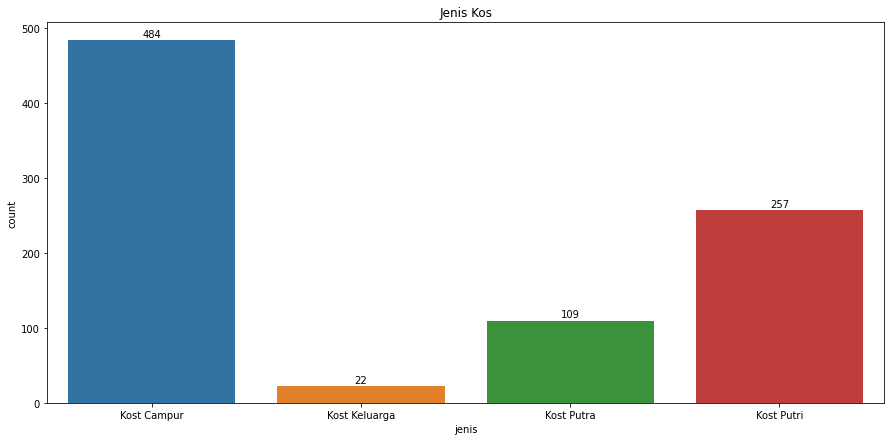

In [82]:
plt.figure(figsize=(15,7))
g = sns.countplot(x=df['jenis'])
plt.title('Jenis Kos')
for p in g.patches:
  g.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+5), ha='center', color='black', size=10)

### Fasilitas

Visualiasi jumlah kost terhadap fasilitas dan jenis kost

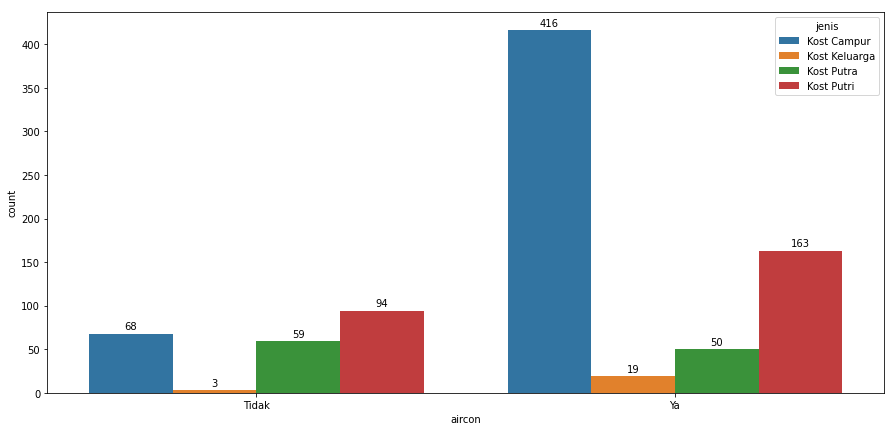

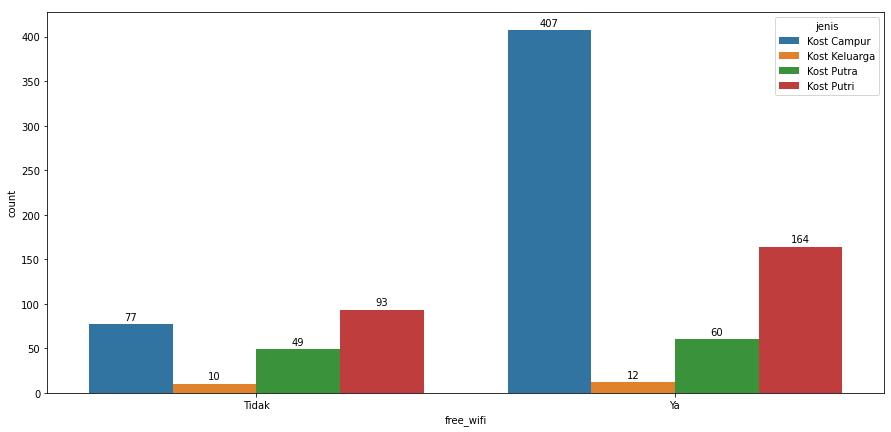

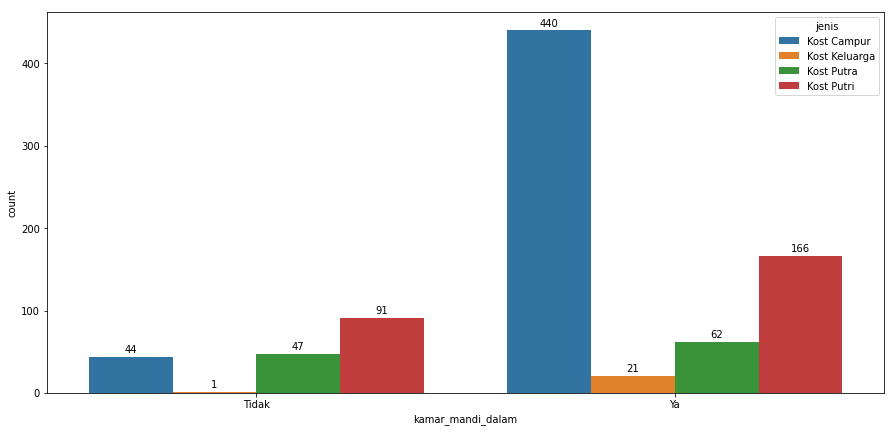

In [83]:
for i in ['aircon', 'free_wifi', 'kamar_mandi_dalam']:
    plt.figure(figsize=(15,7))
    g = sns.countplot(data=df, x=i, hue="jenis")
    for p in g.patches:
        g.annotate(f'\n{p.get_height()}', (p.get_x()+0.1, p.get_height()+5), ha='center', color='black', size=10)

Tidak ada perbedaan distribusi yang signifikan antara jenis kost berdasarkan fasilitasnya. Baik untuk setiap fasilitas, kost camput selalu menjadi urutan pertama, kost putri kedua, kost putra ketiga dan diikuti kost keluarga. Pola ini juga mengikuti distribusi jenis kost secara keseluruhan.

### Boxplot Harga

In [84]:
df.describe()

,harga
count,8.720000e+02
mean,1.825345e+06
std,9.535121e+05
min,4.000000e+05
25%,1.000000e+06
50%,1.650000e+06
75%,2.300000e+06
max,5.000000e+06


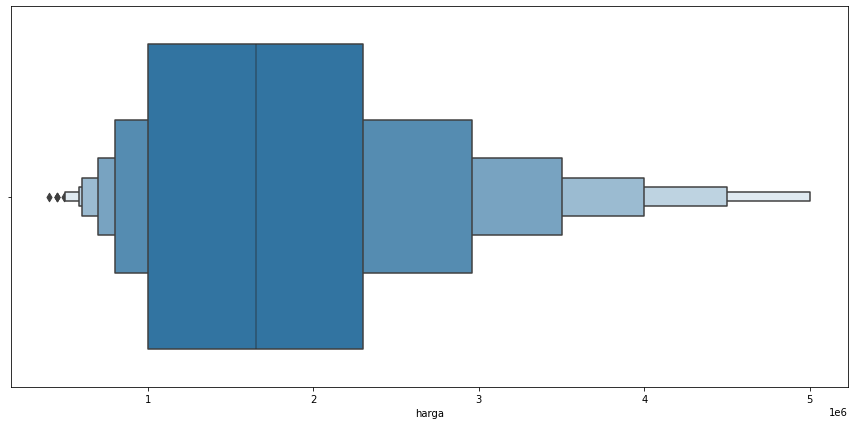

In [85]:
plt.figure(figsize=(15,7))
sns.boxenplot(x=df['harga']);

Analisis harga untuk seluruh kost-kostan. Terlihat persebaran terbanyak harga kostan berada pada rentang 1 hingga 2.3 juta.

## Analisis Harga Terhadap Fasilitas

Analisis ini untuk membandingkan dan melihat persebaran harga untuk kost dengan fasilitas lengkap (ac, wifi dan kamar mandi dalam) serta kost dengan fasilitas yang hanya mempunyai fasilitas wifi & ac dan juga kost dengan fasilitas yang hanya wifi & kamar mandi dalam.

Kenapa selalu ada wifi dalam tahap analisis? Ini dapat dikatakan subjektif karena dibangun di atas asumsi bahwa free wifi sudah termasuk kebutuhan mendasar dalam memilih kost-kostan. Maka dari itu cakupan analisis selalu menyertakan wifi sebagai fasilitas yang ada.

In [86]:
wifi = df['free_wifi'] == 'Ya'
ac = df['aircon'] == 'Ya'
no_ac = df['aircon'] == 'Tidak'
kamar_mandi = df['kamar_mandi_dalam'] == 'Ya'
no_kamar_mandi = df['kamar_mandi_dalam'] == 'Tidak'

lengkap = df[ac & wifi & kamar_mandi]
wifi_kamar_mandi = df[wifi & kamar_mandi & no_ac]
wifi_ac = df[ac & wifi & no_kamar_mandi]
# # Alternatif menggunakan .loc
# lengkap = df.loc[(df[['aircon', 'free_wifi','kamar_mandi_dalam']]=='Ya').all(axis=1)]

print(lengkap.shape)
lengkap.head()

(512, 10)


,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
8,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EKSLUSIF DI JAKARTA SELATAN,850000,Kost Campur,JL. Kapten tendean no.2A (dekat kampus interst...,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Mesin Cuci (Cuci Sendiri)', 'Parkir..."
11,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Premium Termurah Daerah Mampang Jakarta S...,1650000,Kost Campur,"Jalan Bank III No 1 Kelurahan Pela Mampang, Ma...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Dapur', 'Air Minum', 'Pembantu..."
13,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Rumah Kita 1A,1800000,Kost Campur,"Pondok Jaya 3 No 1A, Pela Mampang, Mampang Pra...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...",['Parkir Motor']


### Fasilitas Lengkap

In [87]:
lengkap.describe()

,harga
count,5.120000e+02
mean,2.269721e+06
std,8.943553e+05
min,8.000000e+05
25%,1.600000e+06
50%,2.000000e+06
75%,2.600000e+06
max,5.000000e+06


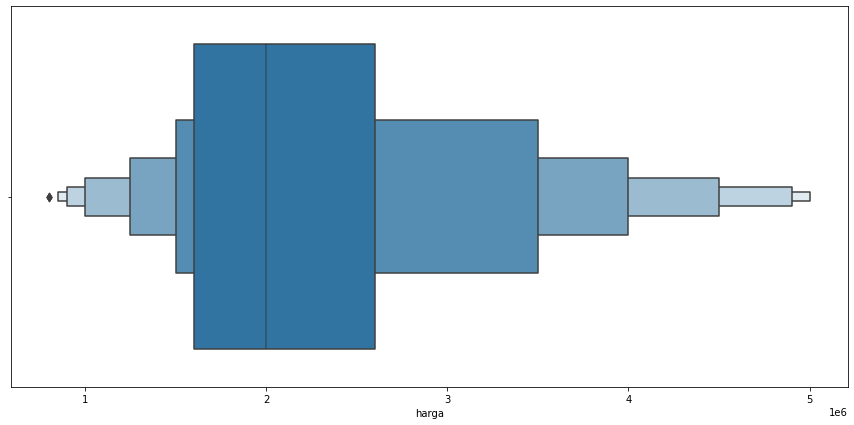

In [88]:
plt.figure(figsize=(15,7))
sns.boxenplot(x=lengkap['harga']);

Dari hasil analisis kost lengkap di atas, diketahui bahwa jumlah kost dengan fasilitas lengkap adalah 512 atau sekitar 58% dari total observasi data yang ada. 50% persebaran data berada pada rentang harga 1,6 juta hingga 2,6 juta rupiah.

Adapun rata-rata harga untuk kost-an lengkap yaitu 2,26 juta rupiah, ini lebih tinggi kurang lebih 400 ribu dibanding rata-rata harga kost pada semua observasi data, yaitu 1,82 juta. Sementara itu, kost lengkap mempunyai median sebesar 2 juta rupiah, lebih besar 350 ribu dari median seluruh observasi data yaitu 1,65 juta rupiah.

### Fasilitas Wifi & Kamar Mandi

In [120]:
print(wifi_kamar_mandi.shape[0])
wifi_kamar_mandi.describe()

35


,harga
count,3.500000e+01
mean,1.054286e+06
std,2.682655e+05
min,5.000000e+05
25%,9.000000e+05
50%,1.000000e+06
75%,1.200000e+06
max,1.700000e+06


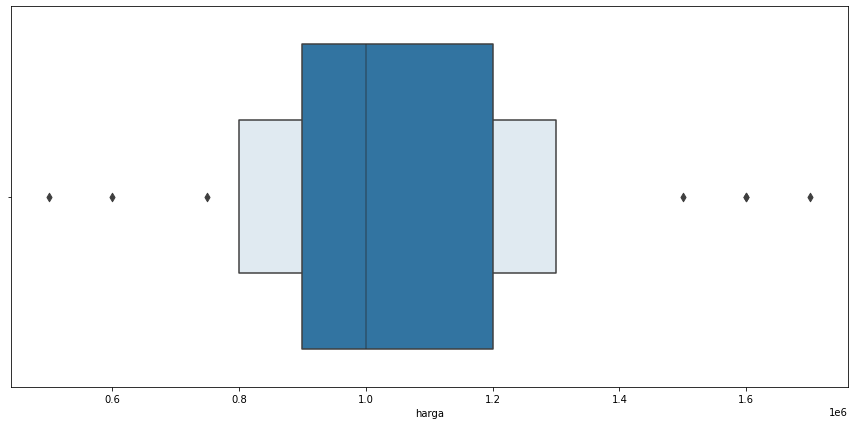

In [105]:
plt.figure(figsize=(15,7))
sns.boxenplot(x=wifi_kamar_mandi['harga']);

Kost dengan fasilitas wifi & kamar mandi dalam berjumlah 35. 50% dari data tersebut tersebar dari rentang harga 900rb hingga 1,2 juta dengan median 1 juta rupiah.

### Fasilitas Wifi & AC

In [121]:
print(wifi_ac.shape[0])
wifi_ac.describe()

46


,harga
count,4.600000e+01
mean,1.509783e+06
std,4.728894e+05
min,6.000000e+05
25%,1.200000e+06
50%,1.500000e+06
75%,1.800000e+06
max,3.000000e+06


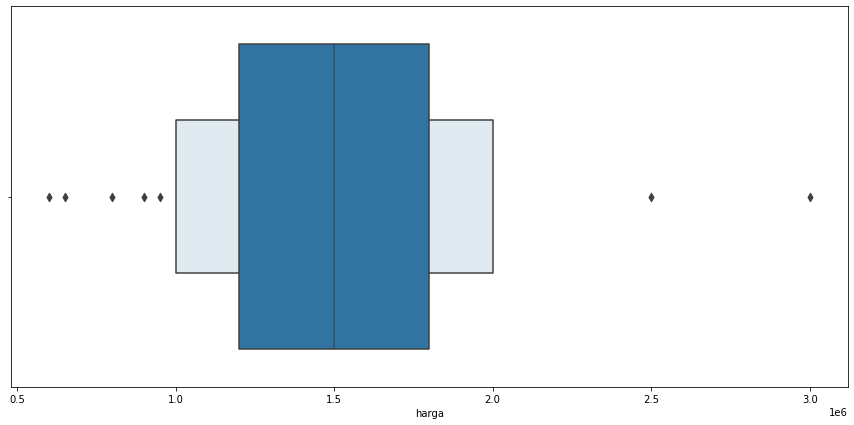

In [92]:
plt.figure(figsize=(15,7))
sns.boxenplot(x=wifi_ac['harga']);

Untuk kost dengan fasilitas wifi & ac berjumlah 46, ini lebih banyak daripada kost dengan wifi & kamar mandi dalam. Adapun 50% persebaran datanya tersebar mulai dari rentang harga 1,2 juta hingga 1,8 juta rupiah dengan median sebesar 1,5 juta.

**Insight**
1. Perbedaan median antara kost dengan fasilitas yang hanya kamar mandi dalam dengan ac adalah 500rb. Begitupun untuk median kost ac dengan fasilitas lengkap bedanya adalah 500ribu. Sehingga jika diurutkan berdasarkan median, maka: kamar mandi dalam < ac < lengkap
2. Jika mencari kost dengan fasilitas kost wifi & ac dengan budget sebesar median, yaitu 1,5 jtua rupiah, maka sebaiknya sekalian mencari kost dengan fasilitias lengkap karena 25% kost fasilitas lengkap memiliki harga di bawah 1,6 juta rupiah.

### Analisis Lanjutan Kost Lengkap

In [116]:
Q1 = lengkap.harga.quantile(0.25)
Q3 = lengkap.harga.quantile(0.75)
IQR = Q3-Q1

outlier_bawah = lengkap[lengkap['harga'] < (Q1 - 1.5 * IQR)]
outlier_atas = lengkap[lengkap['harga'] > (Q3 + 1.5 * IQR)]

print("Jumlah kos lengkap dengan harga di bawah %i adalah = %i" % ((Q1 - 1.5 * IQR), outlier_bawah.shape[0]))
print("Jumlah kos lengkap dengan harga di atas %i adalah = %i" % ((Q3 + 1.5 * IQR), outlier_atas.shape[0]))

Jumlah kos lengkap dengan harga di bawah 100000 adalah = 0
Jumlah kos lengkap dengan harga di atas 4100000 adalah = 25


Karena tidak adanya kost lengkap outlier bawah (harga 100rb rupiah, terlalu rendah untuk harga kost), maka akan dilakukan analisis lanjutan untuk kost lengkap di bawah harga median kost kamar mandi dalam, yaitu 1 juta rupiah.

In [119]:
extreme_underprice = lengkap['harga'] < 1000000
underpriced = lengkap[extreme_underprice]

print("Jumlah kost lengkap dengan harga di bawah 1 juta = %i\nDaftar kost underpriced:" % underpriced.shape[0])
underpriced

Jumlah kost lengkap dengan harga di bawah 1 juta = 10
Daftar kost underpriced:


,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
8,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EKSLUSIF DI JAKARTA SELATAN,850000,Kost Campur,JL. Kapten tendean no.2A (dekat kampus interst...,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Mesin Cuci (Cuci Sendiri)', 'Parkir..."
37,https://www.sewakost.com/jakarta/selatan/kost-...,"KOST LENTENG AGUNG ""Khusus Wanita""",800000,Kost Putri,"Jl.Guru No.21 Rt.006/ 002, Lenteng Agung Jakar...",Ya,Ya,Ya,"['Spring Bed', 'Free WiFi', 'AC', 'Kamar Mandi...","['Ruang Makan', 'Dapur', 'Keamanan', 'Parkir M..."
83,https://www.sewakost.com/jakarta/selatan/terim...,Terima Kost di Lokasi strategis,900000,Kost Campur,"Jl Rambutan, Kel Manggarai Selatan, belakang M...",Ya,Ya,Ya,"['AC', 'Kamar Mandi Dalam']","['Dapur', 'Parkir Motor']"
185,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Griya Baiti Jannati,900000,Kost Campur,Jl. Kalibata Utara V Rt. 008 Rw. 02 No. 16,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."
201,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EKSKLUSIF DI JAKARTA SELATAN,800000,Kost Campur,"Jl. Kapten Tendean no.2A Pela Mampang, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Free WiFi', 'AC', 'TV', 'Kulka...","['Dapur', 'Mesin Cuci (Cuci Sendiri)', 'Parkir..."
240,https://www.sewakost.com/jakarta/selatan/kost-...,Kost jaksel ac dan non ac free listrik air par...,900000,Kost Keluarga,Jagakarsa ciganjur,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Televisi', 'Dapur', 'Mesin Cuc..."
296,https://www.sewakost.com/jakarta/selatan/kost-...,KOST PUTRI,850000,Kost Putri,"Jl. Kebagusan 1 Gang Asem No 111, RT/RW 07/07",Ya,Ya,Ya,"['Perabot', 'Free WiFi', 'AC', 'Kamar Mandi Da...",['Parkir Motor']
503,https://www.sewakost.com/jakarta/selatan/kost-...,KOST GRIYA BAITI JANNATI,900000,Kost Campur,JL. KALIBATA UTARA V RT.008/02 NO. 16 PANCORAN...,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'Kamar ...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."
506,https://www.sewakost.com/jakarta/selatan/d-quo...,"d""orange@jurangmangu",800000,Kost Campur,"jl.Kalimongso RT02/RW01,jurangmangu tangsel",Ya,Ya,Ya,"['AC', 'TV', 'Kamar Mandi Dalam']",['Parkir Motor']
876,https://www.sewakost.com/jakarta/selatan/kos-h...,Kos Hijau Cilandak,850000,Kost Putri,Jl kramat Gang Musholla no 55 rt 014 rw 01 Cil...,Ya,Ya,Ya,[],[]


Terdapat 10 kost lengkap underpriced dengan harga sebanding dengan median kost fasilitas kamar mandi dalam.

**Insight:**

Jika ingin mencari kost dengan budget 1 juta, kemungkinan akan mendapatkan kost dengan fasilitas kamar mandi dalam, namun dapat juga mencari kost lengkap dengan harga underpriced ini.

# Kesimpulan

Pada notebook ini, telah berhasil dilakukan scraping data kost di Jakarta Selatan bersumber dari sewakost.com. Analisis yang dilakukan antara lain melihat persebaran jenis kost-an, dimana kost campur menjadi jenis kost dominan serta kost dengan fasilitas lengkap juga dominan dibandingkan dengan kost dengan fasilitas yang kurang lengkap. Selain itu dilakukan juga analisis harga terhadap fasilitas kost untuk mengetahui persebaran data dan harga kost berdasarkan fasilitasnya.

Adapun hal yang dapat diimprove kedepannya:
1. Meningkatkan jumlah data yang discraping, berhubung notebook ini hanya scraping 40 dari 89 total halaman kost di Jakarta Selatan.
2. Analisis untuk kost tanpa fasilitas ac, kamar mandi dalam dan free wifi
3. Analisis kost berdasarkan fasilitas kamar dan fasilitas bersama